https://www.youtube.com/watch?v=rL7Mvl2-XIM

# Importação de bibliotecas

In [1]:
import numpy as np # criação e manipulação de vetores
import matplotlib.pyplot as plt # graficos
import pandas as pd # read csv file

# Formatação para gráficos

In [2]:
ft = 16
plt.rcParams.update({'font.size':ft})

# Leitura de base de dados

In [3]:
df = pd.read_excel('data.xlsx')

In [4]:
df

,T,k
0,300,6706
1,298,6698
2,330,6657
3,349,6880
4,364,6791
5,353,6917
6,370,7087
7,378,7043
8,373,7175
9,395,7236


A estimação de parâmetros envolve o ajuste de parâmetros em um modelo e refere-se a um problema de otimização. 

Em muitos casos, uma equação diferencial linear de primeira ordem pode aproximar a evolução de muitos sistemas. Os parâmetros desconhecidos para o sistema que iremos estudar como estudo de caso incluem o fator pré-exponencial ($A$) e a energia de ativação ($E_a$).

Nosso modelo:

$$
k(T) = A\cdot e^{-\frac{E_a}{RT}}
$$

In [5]:
R = 8.31451

O conjunto de dados em df corresponde a dados medidos experimentalmente.

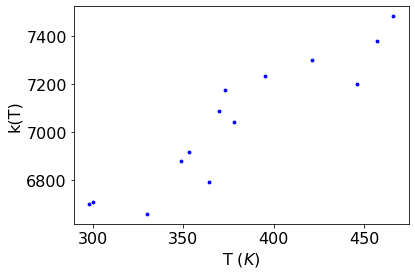

In [6]:
color1 = 'blue'
plt.xlabel('T ($K$)')
plt.ylabel('k(T)')
plt.scatter(df['T'],df['k'],c = color1,marker = 'o',s = 8)

plt.savefig('OriginalData.png',format='png',dpi = 600,bbox_inches = 'tight')
plt.show()

# Apresentação do problema a ser resolvido

Ajuste os dados a um sistema linear de primeira ordem estimando $E_a$ e $A$. Determine os intervalos de confiança de $95 \%$ e $99 \%$ para os parâmetros.

# Começando a pensar no problema de estimação de parâmetros...

In [8]:
df['T']

0     300
1     298
2     330
3     349
4     364
5     353
6     370
7     378
8     373
9     395
10    421
11    446
12    457
13    466
Name: T, dtype: int64

In [7]:
modelo = lambda k1,k2,Temp: k1*np.exp(-k2/(R*Temp))

In [9]:
def simulacao(par,T_K):
    dftemp = df.copy()
    dftemp['km'] = modelo(par[0],par[1],T_K) # km = k modelo
    dftemp['error'] = (dftemp['k'] - dftemp['km'])**2
    SSE = dftemp['error'].sum() # residual sum of squares
    return SSE,dftemp

In [10]:
param = [10000,1000]
simulacao(param,df['T'])

(805697.7383218207,
       T     k           km          error
 0   300  6706  6697.133021      78.623317
 1   298  6698  6679.137658     355.787940
 2   330  6657  6945.718927   83358.618594
 3   349  6880  7084.909704   41987.986790
 4   364  6791  7186.242384  156216.542027
 5   353  6917  7112.630504   38271.294073
 6   370  7087  7224.850389   19002.729748
 7   378  7043  7274.725445   53696.681646
 8   373  7175  7243.763838    4728.465419
 9   395  7236  7375.029140   19329.101720
 10  421  7301  7515.023629   45806.113838
 11  446  7200  7636.334208  190387.540649
 12  457  7379  7686.062110   94287.139121
 13  466  7484  7725.228343   58191.113440)

- Vamos testar outros valores de parâmetros para ver se o SSE diminui

In [11]:
param = [20000,1000]
simulacao(param,df['T'])

(778211232.543961,
       T     k            km         error
 0   300  6706  13394.266042  4.473290e+07
 1   298  6698  13358.275316  4.435927e+07
 2   330  6657  13891.437853  5.233709e+07
 3   349  6880  14169.819408  5.314147e+07
 4   364  6791  14372.484768  5.747891e+07
 5   353  6917  14225.261008  5.341068e+07
 6   370  7087  14449.700778  5.420936e+07
 7   378  7043  14549.450889  5.634680e+07
 8   373  7175  14487.527676  5.347306e+07
 9   395  7236  14750.058280  5.646107e+07
 10  421  7301  15030.047258  5.973817e+07
 11  446  7200  15272.668415  6.516798e+07
 12  457  7379  15372.124219  6.389003e+07
 13  466  7484  15450.456686  6.346443e+07)

In [12]:
param = [2000,1000]
simulacao(param,df['T'])

(438231909.702279,
       T     k           km         error
 0   300  6706  1339.426604  2.880011e+07
 1   298  6698  1335.827532  2.875289e+07
 2   330  6657  1389.143785  2.775031e+07
 3   349  6880  1416.981941  2.984457e+07
 4   364  6791  1437.248477  2.866266e+07
 5   353  6917  1422.526101  3.018924e+07
 6   370  7087  1444.970078  3.183250e+07
 7   378  7043  1454.945089  3.122636e+07
 8   373  7175  1448.752768  3.278991e+07
 9   395  7236  1475.005828  3.318905e+07
 10  421  7301  1503.004726  3.361675e+07
 11  446  7200  1527.266842  3.217990e+07
 12  457  7379  1537.212422  3.412648e+07
 13  466  7484  1545.045669  3.527118e+07)

- Bom, é melhor fazermos isso através de um método de otimização. Ele irá procurar o ponto ótimo, vamos lá:

# Aplicando modelo de otimização

Ver a seguinte referência:
- https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html

In [13]:
from scipy.optimize import minimize

## Criando nossa função objetivo

In [14]:
def Fobj(x):
    SSE,df2 = simulacao(x,df['T'])
    return SSE

Uma vez que criamos nossa função objetivo, sem considerar os erros experimentais, estamos assumindo a hipótese de que os experimentos foram muito bem feitos e os erros experimentais podem ser desprezados. Como a nossa função objetivo é a métrica SSE, a chamamos de **função objetivo de mínimos quadrados**. 

Para mais informações sobre formulação de função objetivo, consulte as seguintes referências: 
- [Análise de Dados Experimentais 1: Fundamentos de Estatística e Estimação de Parâmetros, autores: Marcio Schwaab e José Carlos Pinto, editora: e-papers, 2007.](http://www.e-papers.com.br/produtos.asp?codigo_produto=2792)

- [wikipedia](https://pt.wikipedia.org/wiki/Método_dos_m%C3%ADnimos_quadrados)

## Nelder-Mead Simplex algorithm (method='Nelder-Mead')¶

In [15]:
x0 = [2000,1000]

In [16]:
resNM = minimize(Fobj, x0, method='nelder-mead',options={'xatol': 1e-8, 'disp': True})

Optimization terminated successfully.
         Current function value: 143607.435777
         Iterations: 114
         Function evaluations: 234


In [17]:
resNM

 final_simplex: (array([[9028.49232071,  770.58653614],
       [9028.4923207 ,  770.58653614],
       [9028.49232071,  770.58653614]]), array([143607.4357767, 143607.4357767, 143607.4357767]))
           fun: 143607.43577670038
       message: 'Optimization terminated successfully.'
          nfev: 234
           nit: 114
        status: 0
       success: True
             x: array([9028.49232071,  770.58653614])

In [18]:
type(resNM)

scipy.optimize.optimize.OptimizeResult

- Valores ótimos encontrados (A e Ea):

In [19]:
resNM.x

array([9028.49232071,  770.58653614])

- Valor final da função objetivo:

In [20]:
resNM.fun

143607.43577670038

## Broyden-Fletcher-Goldfarb-Shanno algorithm (method='BFGS')

In [21]:
x0 = [2000,1000]

In [22]:
resBFGS = minimize(Fobj, x0, method='BFGS',options={'disp': True})

         Current function value: 143607.435779
         Iterations: 18
         Function evaluations: 255
         Gradient evaluations: 82


In [23]:
resBFGS.x

array([9028.48898945,  770.5854663 ])

## Comparando os métodos de otimização

In [24]:
result = pd.DataFrame({'SSE':[resNM.fun,resBFGS.fun],
             'A':[resNM.x[0],resBFGS.x[0]],
             'Ea':[resNM.x[1],resBFGS.x[1]],
             '$N_{it}$':[resNM.nit,resBFGS.nit],
             '$N_{fun_{eval}}$':[resNM.nfev,resBFGS.nfev]},
             index = ['NM','BFGS'])

In [25]:
result

,SSE,A,Ea,$N_{it}$,$N_{fun_{eval}}$
NM,143607.435777,9028.492321,770.586536,114,234
BFGS,143607.435779,9028.488989,770.585466,18,255


## Atividade

1. Escolha pelo menos mais 2 métodos de otimização e estime novamente os parâmetros $Ea$ e $A$ do modelo de Arrhenius. 
2. Complete o DataFrame *result* com os resultados desses 2 métodos testados. 
3. Analise a tabela *result*, na sua opinião qual foi o método de otimização que teve o melhor resultado? Por quê?